# 1. 모듈 불러오기

In [1]:
# from IPython.core.display import display, HTML 
# display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# !pip install pandas_datareader

In [3]:
# !pip install pmdarima

In [43]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
#sns.set_style("white")
%matplotlib inline

import itertools

# 2. 데이터 불러오기

In [27]:
# 데이터 1
# CMAQ daily_pm10 20180701_20211001

In [47]:
data = pd.read_excel('CMAQ_daily.xlsx')
data = data.rename(columns = {'DLOGDATE':'day', 'TMS_PM10':'PM10'})
data['day'] = pd.to_datetime(data['day'])
data = data.set_index('day')

In [50]:
data = data.iloc[:200,:1]

In [51]:
data

,PM10
day,
2018-07-01,23
2018-07-02,29
2018-07-03,15
2018-07-04,27
2018-07-05,32
...,...
2019-01-12,37
2019-01-13,76
2019-01-14,65


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1188 entries, 2018-07-01 to 2021-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PM10    1188 non-null   int64
dtypes: int64(1)
memory usage: 18.6 KB


# 3. Box-Jenkins ARIMA Procedure

1. Data preprocessing(전처리)
2. Identify model to be tentatively entertained(대략적인 모델 구축)
3. Estimate parameters
4. Diagnosis check
5. Use Model to forecast

## 3.1 Data preprocessing

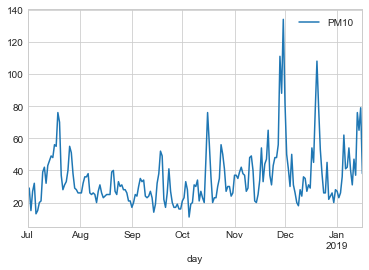

In [52]:
# Raw data plotting
fig = data.plot()

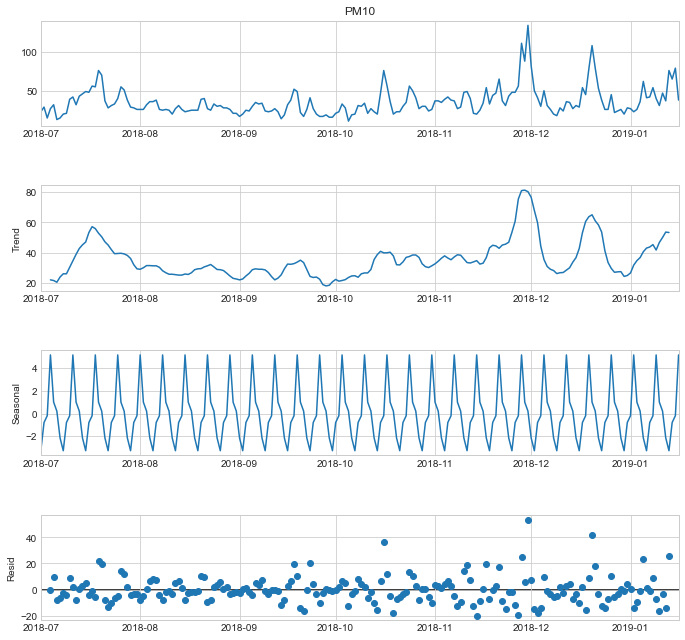

In [54]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages

# Observed : 관측데이터
# Trend : 추세
# Seasonal : 주기성
# resid : residuals

decomposition = sm.tsa.seasonal_decompose(data['PM10'], model = 'additive', period = 7) # period는 row 수
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

## 3.2 Identify Model to be Tentatively Entertained 대략적인 모델 구성해보기

In [55]:
# Train:Test = 8:2 로 분리
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle = False)

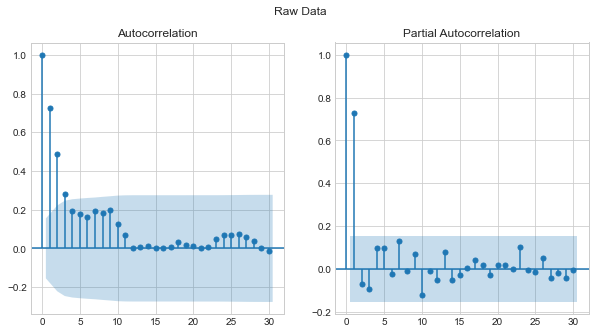

In [56]:
# ACF, PACF plot

# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax = ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax = ax[1]); # ; 를 붙여줘야 두번 안그려짐
# non-stationary 하다는것을 확인 가능

### Differencing 적용

In [57]:
# differencing
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['PM10'].diff()
diff_train_data = diff_train_data.dropna() # 차분하면 1st row가 nan이 되므로 dropna로 없애줘야함

print('######### Raw Data #########')
print(train_data)
print('######### Differenced Data #########')
print(diff_train_data)

######### Raw Data #########
            PM10
day             
2018-07-01    23
2018-07-02    29
2018-07-03    15
2018-07-04    27
2018-07-05    32
...          ...
2018-12-03    41
2018-12-04    30
2018-12-05    50
2018-12-06    31
2018-12-07    26

[160 rows x 1 columns]
######### Differenced Data #########
day
2018-07-02     6.0
2018-07-03   -14.0
2018-07-04    12.0
2018-07-05     5.0
2018-07-06   -19.0
              ... 
2018-12-03    -9.0
2018-12-04   -11.0
2018-12-05    20.0
2018-12-06   -19.0
2018-12-07    -5.0
Name: PM10, Length: 159, dtype: float64


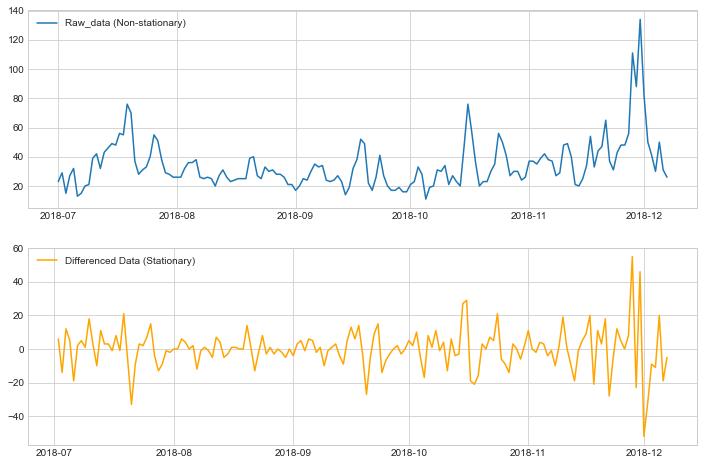

In [58]:
# Differenced data plot
plt.figure(figsize = (12, 8))

plt.subplot(211) # subplot (2, 1, 1)을 의미. 2row/1column 격자에서 1번째 그래프 그림
plt.plot(train_data['PM10'])
plt.legend(['Raw_data (Non-stationary)'])

plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference (t- (t-1))
plt.legend(['Differenced Data (Stationary)'])

plt.show()
# Stationarity를 p-value로 확인하는 방법도 있음.

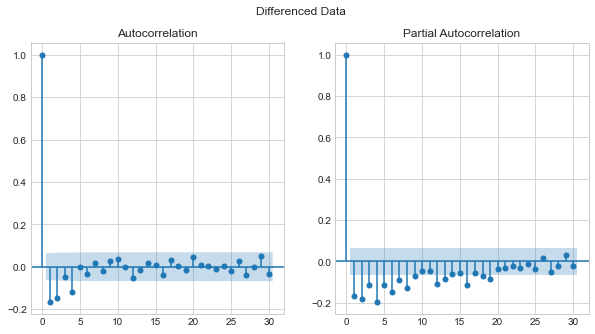

In [12]:
# ACF, PACF plot
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags = 30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags = 30, ax=ax[1]);

### Graphical method에 따르면 -> ACF가 지수적 감소하며 소멸하는 sine 함수 형태를 띄기 때문에 AR(1) model 이용

### 3.3 Estimate Paramters

In [59]:
# ARIMA model fitting
model = ARIMA(train_data.values, order = (1, 1, 0))
model_fit = model.fit()
model_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  159
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -626.761
Method:                       css-mle   S.D. of innovations             12.465
Date:                Fri, 08 Oct 2021   AIC                           1259.523
Time:                        16:04:33   BIC                           1268.729
Sample:                             1   HQIC                          1263.261
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0185      0.922      0.020      0.984      -1.788       1.825
ar.L1.D.y     -0.0729      0.079     -0.924      0.356      -0.228       0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.7149           +0.0000j           13.7149            0.5000
-----------------------------------------------------------------------------
"""

### 3.4.1 Diagnosis Check - ARIMA

In [60]:
print('Examples of parameter combinations for ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0 ,3)
pdq = list(itertools.product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(train_data.values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >>  AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for ARIMA...
ARIMA: (0, 1, 0) >>  AIC : 1258.37
ARIMA: (0, 1, 1) >>  AIC : 1259.37
ARIMA: (0, 1, 2) >>  AIC : 1257.68
ARIMA: (1, 1, 0) >>  AIC : 1259.52


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

ARIMA: (1, 1, 1) >>  AIC : 1240.87
ARIMA: (1, 1, 2) >>  AIC : 1242.1
ARIMA: (2, 1, 0) >>  AIC : 1261.0
ARIMA: (2, 1, 1) >>  AIC : 1241.96


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


ARIMA: (2, 1, 2) >>  AIC : 1242.61


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarni

In [61]:
# Search optimal parameters

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal
# pdq가 2,1,1일때 최적

[((1, 1, 1), 1240.87)]

In [62]:
model_opt = ARIMA(train_data.values, order = optimal[0][0]) # 아까 찾은 최적 pdq 값 넣고 다시 돌리기
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  159
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -616.436
Method:                       css-mle   S.D. of innovations             11.561
Date:                Fri, 08 Oct 2021   AIC                           1240.871
Time:                        16:04:36   BIC                           1253.147
Sample:                             1   HQIC                          1245.856
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0857      0.066      1.295      0.195      -0.044       0.215
ar.L1.D.y      0.7143      0.057     12.564      0.000       0.603       0.826
ma.L1.D.y     -1.0000      0.028    -36.057      0.000      -1.054      -0.946
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4000           +0.0000j            1.4000            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### 3.5.1 USE model to Forecase - ARIMA

In [63]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0] # upper prediction interval value
predicted_lb = prediction[2][:,1] # lower 
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

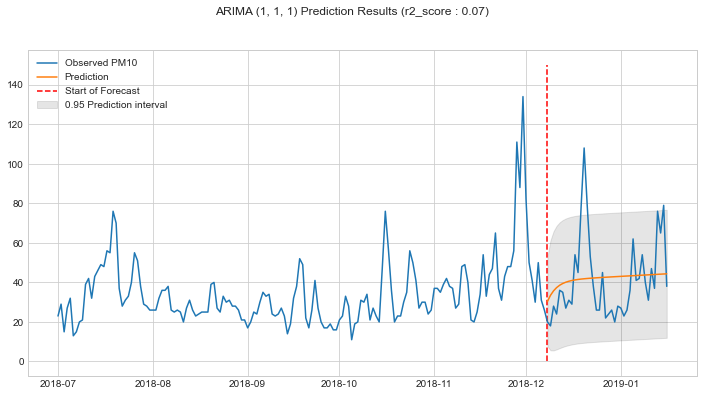

In [65]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(list(data.index), data.values, label = 'Observed PM10')
ax.vlines(predict_index[0], 0, 150, linestyle = '--', color = 'r', label = 'Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2, 2)})')
plt.show()

### 3.4.2 Diagnosis check - SARIMA
- Seasonality 반영

In [ ]:
# Paramater search

print('Examples of parameter combinations for Seansonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0 ,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))] # 12는 12개 data마다 seasonality가 있다고 가정 -> s값임. : 요것도 물론 iteration으로 최적화된 값 search 가능한데, 일단 그냥 12로 돌림.

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order = (i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >>  AIC : {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic, 2))
            params.append((i, j))
        except:
            continue

Examples of parameter combinations for Seansonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 365) >>  AIC : 2.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((2, 1, 2), (0, 1, 1, 12)), 7414.36)]

In [30]:
model_opt = SARIMAX(train_data.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1]) # -> 오류로 안됨 ㅠㅠ
# model_opt = SARIMAX(train_data.values, order = (1,1,0), seasonal_order = (1,1,2,12))
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  950
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood               -3791.875
Date:                                 Fri, 08 Oct 2021   AIC                           7593.750
Time:                                         13:26:35   BIC                           7617.963
Sample:                                              0   HQIC                          7602.981
                                                 - 950                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1675      0.023     -7.288      0.000      -0.213      -0.122
ar.S.L12      -0.1442      0.589     -0.245      0.807      -1.299       1.010
ma.S.L12      -0.9083      0.630     -1.442      0.149      -2.142       0.326
ma.S.L24      -0.0906      0.607     -0.149      0.881      -1.279       1.098
sigma2       181.1770     68.761      2.635      0.008      46.408     315.946
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):               351.85
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.2 Use model to Forecase - SARIMA

In [21]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

NameError: name 'model_opt_fit' is not defined

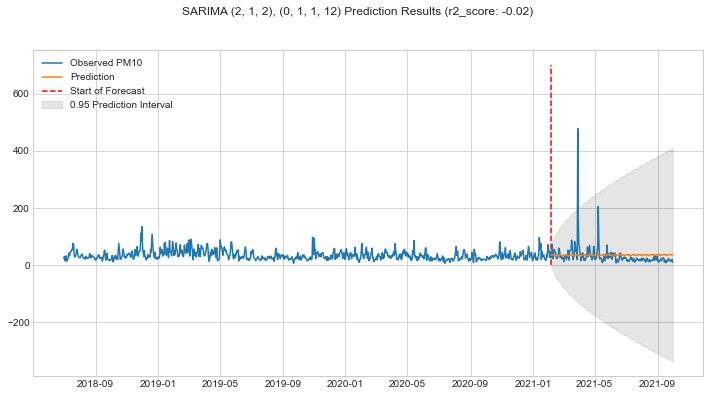

In [32]:
fig, ax = plt.subplots(figsize = (12, 6))
# data.plot(ax = ax);
ax.plot(list(data.index), data.values, label = 'Observed PM10')
ax.vlines(predict_index[0], 0, 700, linestyle = '--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2_score: {round(r2, 2)})') # 오류로 optimal 은 다른 값임
plt.show()

### 3.4.3 Diagnosis Check - Auto_ARIMA!!

In [39]:
# Parameter search

auto_arima_model = auto_arima(train_data, start_p = 1, start_q = 1, 
                             max_p = 3, max_q = 3, m = 1, seasonal = True,
                             d=1, D=1,
                             max_P = 3, max_Q = 3,
                             trace = True,
                             error_action='ignore',
                             suppress_warnings = True,
                             stepwise = False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=10571.969, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=10539.665, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=10539.121, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=10540.989, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=10537.908, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=10539.373, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=10541.080, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=10539.249, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=10541.215, Time=0.69 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=10492.340, Time=2.42 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=10541.059, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=10538.688, Time=2.92 sec

Best model: 

In [40]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2188
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5240.170
Date:                Fri, 08 Oct 2021   AIC                          10492.340
Time:                        16:01:33   BIC                          10526.481
Sample:                             0   HQIC                         10504.819
                               - 2188                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.42e-05      0.004      0.007      0.995      -0.007       0.007
ar.L1          1.9222      0.005    404.325      0.000       1.913       1.931
ar.L2         -0.9898      0.005   -210.394      0.000      -0.999      -0.981
ma.L1         -1.9073      0.009   -220.092      0.000      -1.924      -1.890
ma.L2          0.9696      0.009    110.532      0.000       0.952       0.987
sigma2         7.0361      0.157     44.778      0.000       6.728       7.344
===================================================================================
Ljung-Box (L1) (Q):                  14.05   Jarque-Bera (JB):               305.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.3 Use model to Forecase - Auto_arima

In [41]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

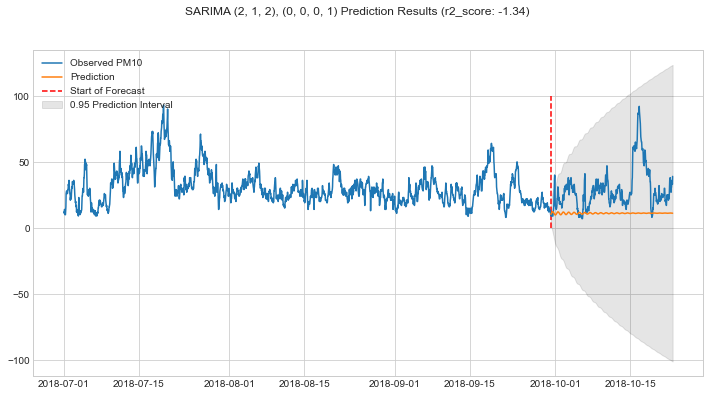

In [42]:
fig, ax = plt.subplots(figsize = (12, 6))
# data.plot(ax = ax);
ax.plot(list(data.index), data.values, label = 'Observed PM10')
ax.vlines(predict_index[0], 0, 100, linestyle = '--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order}, {auto_arima_model.seasonal_order} Prediction Results (r2_score: {round(r2, 2)})') # 오류로 optimal 은 다른 값임
plt.show()

## 4. Case Study : 주가 예측

In [144]:
def get_code(df, name): # df에서 name에 해당하는 종목의 종목코드만 가져오기
    code = df.query("name == '{}'".format(name))['code'].to_string(index=False)
    code = code.strip() # 양 끝에 존재하는 공백과 \n 제거해줌
    return code

In [145]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data  # 상장법인에 대한 정보가 담긴 테이블

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DRB동일,4840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://drbworld.com,부산광역시
1,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
2,GS,78930,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시
3,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
4,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시
...,...,...,...,...,...,...,...,...,...
2457,타임기술,318660,소프트웨어 개발 및 공급업,"ILS(종합군수지원), IETM(전자식기술교범), CBT(전자식교보재), 기술번역",2021-06-24,12월,주양효,http://timett.co.kr,경상남도
2458,툴젠,199800,자연과학 및 공학 연구개발업,"유전자가위 (유전체 교정 도구) 및 이를 이용한 유전자세포치료제, 고부가가치 가축,...",2014-06-25,12월,"김영호, 이병화(각자 대표이사)",http://www.toolgen.com,서울특별시
2459,플럼라인생명과학,222670,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피",2015-07-28,12월,김앤토니경태,http://www.plsdna.com,서울특별시
2460,한국미라클피플사,331660,기타 화학제품 제조업,"은나노스텝, 닥터오렌지 등",2019-10-28,12월,이호경,http://www.kmpc.co.kr,경기도


In [146]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns = {'회사명':'name', '종목코드':'code'})
code_data.code = code_data.code.map('{:06d}'.format) # code_data df의 'code' column에서 map 함수로 0을 채워넣은 6자리 숫자 포맷으로 다시 저장해줌

In [148]:
stock_code = get_code(code_data, 'LG이노텍')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)
'''
High : 고가
Low : 저가
Open : 시가
Close : 종가
Volume : 거래량
Adj Close : 수정종가
'''
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-05,77500.0,76000.0,77500.0,76200.0,147445.0,75111.515625
2016-10-06,76700.0,74400.0,76200.0,74500.0,241129.0,73435.796875
2016-10-07,75800.0,74100.0,74500.0,75200.0,162062.0,74125.789062
2016-10-10,78700.0,75500.0,75900.0,78200.0,239458.0,77082.945312
2016-10-11,80200.0,77700.0,79400.0,78200.0,217847.0,77082.945312
...,...,...,...,...,...,...
2021-09-27,223000.0,215000.0,218500.0,220500.0,232159.0,220500.000000
2021-09-28,220500.0,210500.0,220000.0,211500.0,327717.0,211500.000000
2021-09-29,209000.0,203500.0,205000.0,207500.0,241079.0,207500.000000


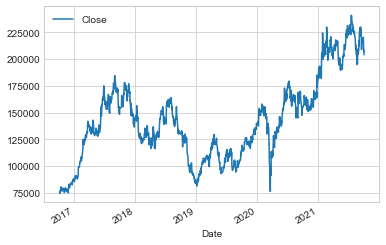

In [149]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()

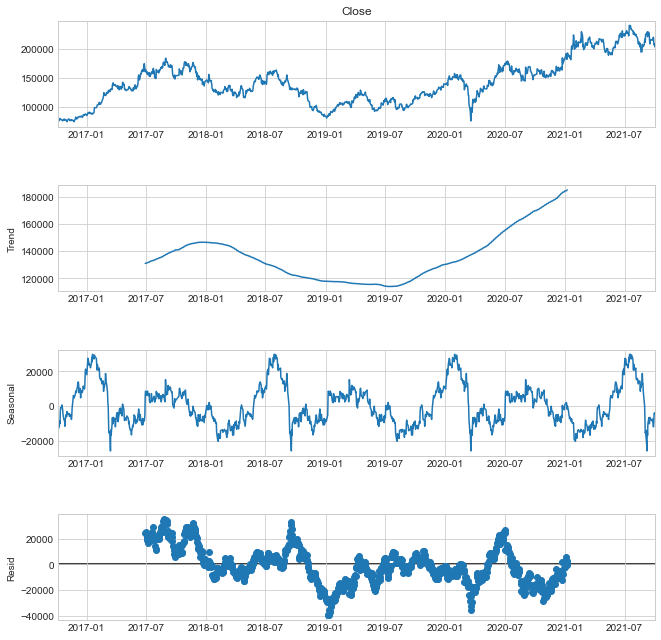

In [170]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages

# Observed : 관측데이터
# Trend : 추세
# Seasonal : 주기성
# resid : residuals

decomposition = sm.tsa.seasonal_decompose(stock_data['Close'], model = 'additive', period = 365) # period는 row 수
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

In [150]:
stock_data_train, stock_data_test = train_test_split(stock_data, test_size = 0.05, shuffle = False)

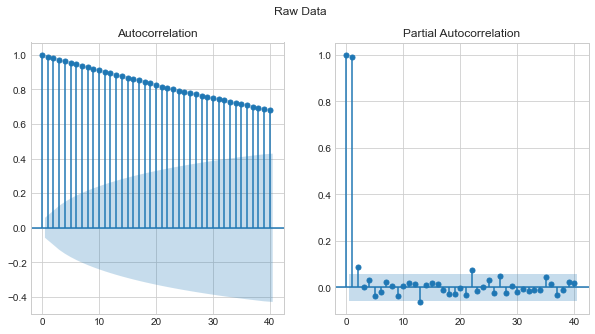

In [151]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags = 40, ax = ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags = 40, ax = ax[1]);

In [152]:
# differenced data plot

diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna() # 차분하면 1st row가 nan이 되므로 dropna로 없애줘야함

print('######### Raw Data #########')
print(stock_data_train)
print('######### Differenced Data #########')
print(diff_stock_data_train)

######### Raw Data #########
               Close
Date                
2016-10-05   76200.0
2016-10-06   74500.0
2016-10-07   75200.0
2016-10-10   78200.0
2016-10-11   78200.0
...              ...
2021-06-25  227500.0
2021-06-28  225000.0
2021-06-29  222500.0
2021-06-30  223000.0
2021-07-01  226500.0

[1160 rows x 1 columns]
######### Differenced Data #########
Date
2016-10-06   -1700.0
2016-10-07     700.0
2016-10-10    3000.0
2016-10-11       0.0
2016-10-12    2400.0
               ...  
2021-06-25   -4000.0
2021-06-28   -2500.0
2021-06-29   -2500.0
2021-06-30     500.0
2021-07-01    3500.0
Name: Close, Length: 1159, dtype: float64


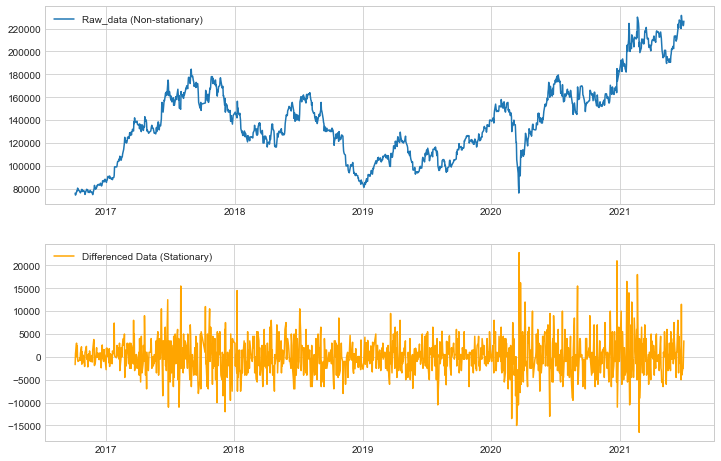

In [153]:
# Differenced data plot
plt.figure(figsize = (12, 8))

plt.subplot(211) # subplot (2, 1, 1)을 의미. 2row/1column 격자에서 1번째 그래프 그림
plt.plot(stock_data_train['Close'])
plt.legend(['Raw_data (Non-stationary)'])

plt.subplot(212)
plt.plot(diff_stock_data_train, 'orange') # first difference (t- (t-1))
plt.legend(['Differenced Data (Stationary)'])

plt.show()
# 1차 차분해도 정상성이 없는딩? log_scale을 한번 더 해줘야 정신차릴듯

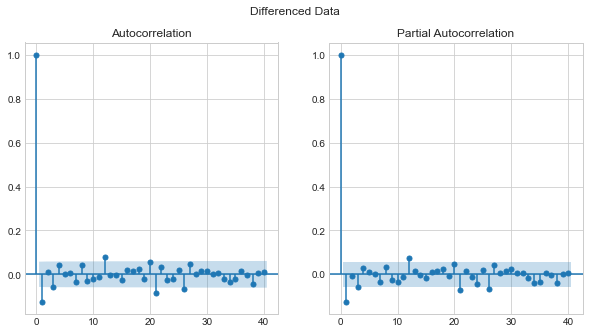

In [154]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags = 40, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags = 40, ax = ax[1]);

In [155]:
# Parameter search

# Parameter search

auto_arima_model = auto_arima(stock_data_train, start_p = 1, start_q = 1, 
                             max_p = 3, max_q = 3, seasonal = False,
                             d=1,
                             trace = True,
                             error_action='ignore',
                             suppress_warnings = True,
                             stepwise = False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22541.650, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22527.380, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22529.388, Time=0.50 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22530.123, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22527.445, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22529.376, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22528.827, Time=2.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22530.215, Time=4.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22529.416, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22531.385, Time=2.53 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22529.978, Time=3.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22529.828, Time=7.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22529.534, Time=1.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22531.190, Time=2.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22529.370, Time=7.26

In [156]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1160
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -11260.690
Date:                Mon, 04 Oct 2021   AIC                          22527.380
Time:                        23:59:18   BIC                          22542.546
Sample:                             0   HQIC                         22533.103
                               - 1160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    146.7100    107.919      1.359      0.174     -64.807     358.227
ma.L1         -0.1058      0.020     -5.193      0.000      -0.146      -0.066
sigma2      1.611e+07   4.37e+05     36.814      0.000    1.52e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               439.80
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(stock_data_test.index)
r2 = r2_score(stock_data_test, predicted_value)

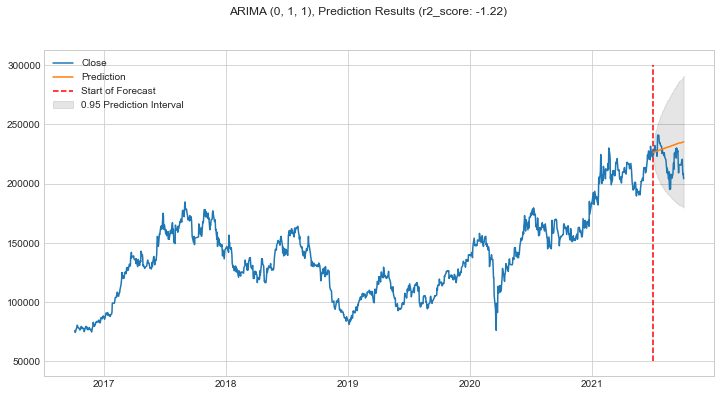

In [161]:
fig, ax = plt.subplots(figsize = (12, 6))
# data.plot(ax = ax);
ax.plot(list(stock_data.index), stock_data.values, label = 'Close')
ax.vlines(predict_index[0], 50000, 300000, linestyle = '--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results (r2_score: {round(r2, 2)})') # 오류로 optimal 은 다른 값임
plt.show()